This notebook evaluates and plots the results of the MIA/AI analysis on the Adult and Purchase100 datasets.
Please, refer to the individual sections for the instructions on how to run the experiments first.

In [2]:
import glob
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
from scipy.special import erf

FIGSIZE = (4, 4/1.6)
DPI = 300

In [3]:
def load_results(file_pattern):
    res = []
    for fname in glob.glob(file_pattern):
        res.append(pd.read_json(fname, lines=True))
    
    if len(res) == 1:
        return res[0]
    
    return pd.concat(res)

# Privacy vs utility

The following should be run after running:

```
$ bash adult-experiments.sh
$ bash purchase100-experiments.sh
```

In [66]:
results_adult = load_results("results/analysis/adult-only-approximate-small*")
results_purchase = load_results("results/analysis/purchase100-*")

In [67]:
results_adult["Bayes-AI"] = results_adult["Bayes-AI-approximate"]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


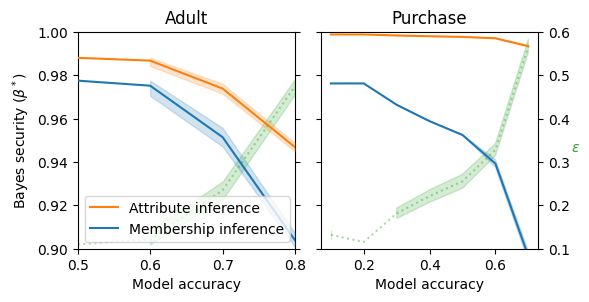

In [120]:
fig, axes = plt.subplots(1, 2, sharey=True, figsize=[1.5*FIGSIZE[0], 1.25*FIGSIZE[1]])

for i, dataset, results in zip([0, 1], ["adult", "purchase"], [results_adult, results_purchase]):
    axes[i].set_title(dataset.title())
    rounded_accuracy = results.accuracy.round(1) # Avoids jitters.

    ax = sns.lineplot(x=rounded_accuracy, y=results["Bayes-AI"], label="Attribute inference", color=sns.color_palette()[1], ax=axes[i])
    sns.lineplot(x=rounded_accuracy, y=results["Bayes-MIA"], label="Membership inference", color=sns.color_palette()[0], ax=axes[i])

    # Epsilon on other axis.
    ax2 = ax.twinx()
    sns.lineplot(x=rounded_accuracy, y=results.epsilon, ax=ax2, color=sns.color_palette()[2], alpha=0.4, ls=":")
    ax2.set_ylim([0.1, 0.6])

    ax.set_zorder(ax2.get_zorder()+1) # First plots on top.
    ax.set_frame_on(False)
    if dataset == "adult":
        ax.set_xlim(0.5, 0.8)
        ax.set_ylim(0.9, 1)
        
        ax2.set_ylabel("")
        ax2.set_yticklabels([])
    elif dataset == "purchase":
        ax2.set_ylabel(r"$\varepsilon$", color=sns.color_palette()[2], rotation=0)
        ax.legend().set_visible(False)
        ax2.legend().set_visible(False)

    ax.set_xlabel("Model accuracy")
    ax.set_ylabel(r"Bayes security ($\beta^*$)")

# Running times

The following should be run after running:

```
$ bash timing-experiments.sh
```

In [4]:
results_no_dp = load_results("results/timing/adult-disable-dp.jsonl")
results_mia = load_results("results/timing/adult-mia.jsonl")
results_accountant = load_results("results/timing/adult-accountant.jsonl")
results_ai_approximate = load_results("results/timing/adult-ai-approximate.jsonl")
results_ai = load_results("results/timing/adult-ai.jsonl")

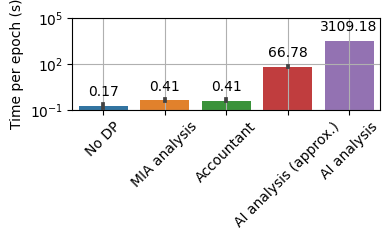

In [15]:
plt.figure(figsize=FIGSIZE)
ax = sns.barplot(pd.DataFrame({
    "No DP": results_no_dp.epoch_time,
    "MIA analysis": results_mia.epoch_time,
    "Accountant": results_accountant.epoch_time,
    "AI analysis (approx.)": results_ai_approximate.epoch_time,
    "AI analysis": results_ai.epoch_time,
}))
#hatches = ["/", "o", "-", "*", "\\"]
#for hatch, patch in zip(hatches, ax.patches):
#    patch.set_hatch(hatch)
ax.bar_label(ax.containers[0], labels=[f'{x:.2f}' for x in ax.containers[0].datavalues], padding=5)
plt.ylabel("Time per epoch (s)")
plt.xticks(rotation=45)
plt.yscale("log")
plt.ylim([0.1, 10**5])
plt.grid()

# AI analysis

The following should be run after running:

```
$ bash adult-experiments-full.sh
$ bash purchase100-experiments.sh
```

**NOTE**: the `adult-experiments-full.sh` script takes a long time to run, as it tests all the values for the sensitive attribute,
rather than using the approximate algorithm.

In [3]:
results_adult = load_results("results/analysis/adult-full-*")

## Approximate AI bound estimation

How good is the approximate method?

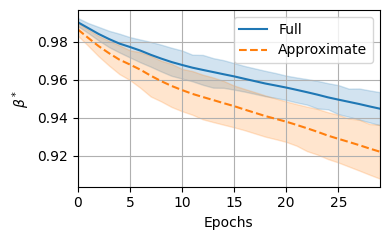

In [5]:
plt.figure(figsize=FIGSIZE)
sns.lineplot(results_adult["Bayes-AI"], label=r"Full", ls="-")
sns.lineplot(results_adult["Bayes-AI-approximate"], label=r"Approximate", ls="--")

plt.xlabel("Epochs")
plt.ylabel(r"$\beta^*$")
plt.legend()
plt.grid()
plt.xlim([0, 29])